In [2]:
%load_ext autoreload
%autoreload 2
import tqdm
import numpy as np
import pandas as pd

import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import DataLoader

from data import load_test_data, generate_training_samples
from dataset import STDataset
from evaluate import Evaluator
from utils import *

from parameter import create_args
from models.ddpm import *
from models.common import get_linear_scheduler
from models.gnn_encoder import GNNEncoder
from models.vae_flow import FlowVAE
from models.vae_gaussian import GaussianVAE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# training_samples = generate_training_samples(num_samples_per_slice=10)
training_samples = generate_training_samples(num_samples_per_slice=10, dominance_threshold=0.5, region_size=750, num_cells=500)

Seeding all randomness with seed=2024


In [3]:
tissue_distribution = count_dominant_tissue(training_samples)
print(tissue_distribution)

{'cortical layer VI': 71, 'striatum': 108, 'cortical layer V': 57, 'cortical layer II/III': 27, 'corpus callosum': 47}


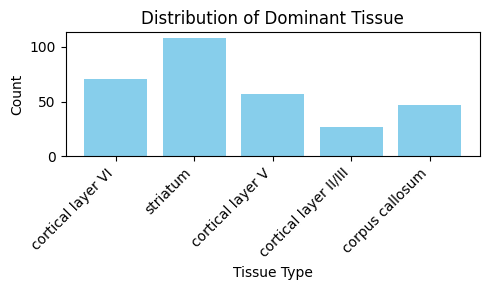

In [4]:
plot_tissue_distribution(tissue_distribution)

In [7]:
# filter_training_samples = filter_training_sample_by_tissue(training_samples, tissue_name="striatum")
# len(filter_training_samples)

In [5]:
tissue_index = {
    'striatum': 0,
    'cortical layer VI': 1,
    'cortical layer V': 2,
    'corpus callosum': 3,
    'cortical layer II/III': 4
    # 'pia mater': 5
}


In [19]:
dataset = STDataset(training_samples)
# dataset = STDataset(filter_training_samples)
# Define a DataLoader to handle batching
# dataloader = DataLoader(dataset, batch_size=10, shuffle=True, num_workers=4)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [81]:
args = create_args()

In [88]:
if args.model == 'gaussian':
    model = GaussianVAE(args).to(args.device)
elif args.model == 'flow':
    model = FlowVAE(args).to(args.device)

In [89]:
total_params = sum(p.numel() for p in model.parameters())
print("Total number of paramete|rs: ", total_params)

Total number of paramete|rs:  230880


In [90]:
# Optimizer and scheduler
optimizer = torch.optim.Adam(model.parameters(), 
    lr=args.lr, 
    weight_decay=args.weight_decay
)

scheduler = get_linear_scheduler(
    optimizer,
    start_epoch=args.sched_start_epoch,
    end_epoch=args.sched_end_epoch,
    start_lr=args.lr,
    end_lr=args.end_lr
)

In [91]:
for epoch in range(args.train_epochs):
    for batch in dataloader:
        positions = batch['positions'].to(args.device)
        expressions = batch['expressions'].to(args.device)
        edge_index = batch['edge_index'].to(args.device)
        metadata = batch['metadata']
        
        # Convert tissue types to integers and move to device
        tissue_labels = torch.tensor([tissue_index[tissue] for tissue in metadata['dominant_tissue']], device=args.device)
        
        # Reset grad and model state
        optimizer.zero_grad()
        model.train()
        
        # Step 1: 训练position的扩散模型
        position_loss = model.get_position_loss(positions, expressions, edge_index, tissue_labels)
        position_loss.backward()
        orig_grad_norm = clip_grad_norm_(model.parameters(), args.max_grad_norm)
        optimizer.step()
        scheduler.step()

        # Step 2: 使用训练好的位置模型生成预测位置
        predicted_positions = model.sample_positions(
            z=torch.randn(positions.size(0), model.args.latent_dim).to(args.device), 
            tissue_labels=tissue_labels, 
            num_points=positions.size(1)
        )
        
        # Reset grad for expression model
        optimizer.zero_grad()

        # Step 3: 训练expression的扩散模型
        expression_loss = model.get_expression_loss(predicted_positions, positions, expressions, edge_index, tissue_labels)
        expression_loss.backward()
        orig_grad_norm = clip_grad_norm_(model.parameters(), args.max_grad_norm)
        optimizer.step()
        scheduler.step()

    print(f"Epoch {epoch}: Position Loss = {position_loss.item()}, Expression Loss = {expression_loss.item()}")
    # print(f"Epoch {epoch}: Position Loss = {position_loss.item()}")
    
    # with torch.no_grad():
    #     z = torch.randn([1, args.latent_dim]).to(args.device)
    #     tissue_labels = torch.tensor([1], device=args.device)
        
    #     # Step 1: Sample positions using the model
    #     pred_coords = model.sample_positions(
    #         z=z, 
    #         tissue_labels=tissue_labels, 
    #         num_points=500
    #     )
        
    #     pos = pred_coords[0].cpu().numpy()
        
    #     plt.scatter(pos[:,0], pos[:,1], color='blue', marker='o')
    #     plt.title("2D Scatter Plot")
    #     plt.xlabel("X-axis")
    #     plt.ylabel("Y-axis")
    #     plt.title(epoch)
    #     plt.show()


Epoch 0: Position Loss = 1.0256785154342651, Expression Loss = 1.1978278160095215
Epoch 1: Position Loss = 0.9100576639175415, Expression Loss = 1.0232185125350952
Epoch 2: Position Loss = 0.7173513174057007, Expression Loss = 1.170446515083313
Epoch 3: Position Loss = 0.7660592794418335, Expression Loss = 1.003709316253662
Epoch 4: Position Loss = 0.6112196445465088, Expression Loss = 1.1460151672363281
Epoch 5: Position Loss = 0.8327428102493286, Expression Loss = 0.9518460035324097
Epoch 6: Position Loss = 0.8246424198150635, Expression Loss = 1.108346939086914
Epoch 7: Position Loss = 0.8661404252052307, Expression Loss = 0.9736054539680481
Epoch 8: Position Loss = 0.6686071157455444, Expression Loss = 0.7175581455230713
Epoch 9: Position Loss = 0.6950305700302124, Expression Loss = 0.7684213519096375
Epoch 10: Position Loss = 0.4755111336708069, Expression Loss = 0.7867855429649353
Epoch 11: Position Loss = 0.676723301410675, Expression Loss = 1.072700023651123
Epoch 12: Position 

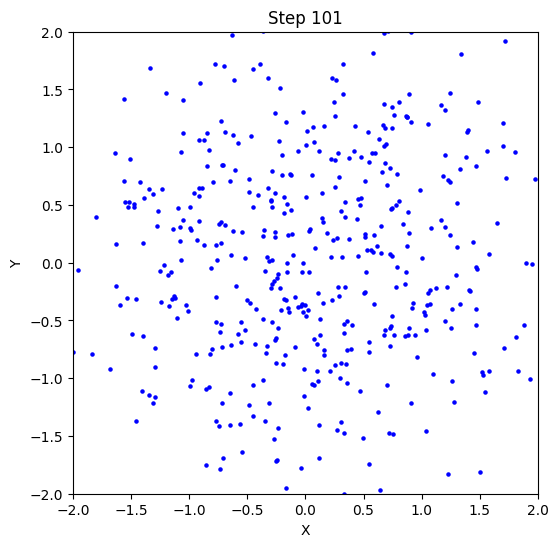

In [92]:
ani = visualize_sampling_process_animation(model=model, num_points=500)
ani.save("./denoising_process_animation_truncated.gif", writer='imagemagick', fps=10)

In [3]:
# all_test_items = load_test_data(num_holes=10, hole_size=750, dominance_threshold=0.5, num_cells=500)
all_test_items = load_test_data(num_holes=10, hole_size=250, dominance_threshold=0.9, num_cells=50)

Seeding all randomness with seed=2024
Donor_id: MsBrainAgingSpatialDonor_1
Slice_id: 0
Donor_id: MsBrainAgingSpatialDonor_2
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_3
Slice_id: 0
Slice_id: 1
Donor_id: MsBrainAgingSpatialDonor_4
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_5
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_6
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_7
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_8
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_9
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_10
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_11
Slice_id: 0
Slice_id: 1
Slice_id: 2
Donor_id: MsBrainAgingSpatialDonor_12
Slice_id: 0
Slice_id: 1


In [4]:
for i, test_item in enumerate(all_test_items):
    print(f"Test Area {i+1}:")
    print(f"  Dominant Tissue: {test_item.test_area.dominant_tissue}")
    print(f"  Number of cells in ground truth: {len(test_item.ground_truth.hole_cells)}")
    
    break

Test Area 1:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50


In [10]:
test_item.test_area.hole_min_x, test_item.test_area.hole_max_x, test_item.test_area.hole_min_y, test_item.test_area.hole_max_y

(-4351.060917283206,
 -4165.913093647361,
 1756.7675920933484,
 1901.7466902596634)

In [6]:
expanded_cells = extract_cells_from_expanded_region(test_item)

In [106]:
test_item.adata

View of AnnData object with n_obs × n_vars = 15660 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 'cell_type_annot', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'batch_condition', 'citation', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'spatial'

In [107]:
test_item.test_area

In [102]:
# Initialize dictionaries to store metrics for both baselines
metrics = {
    'Diffusion': {
        'mse': [],
        'f1': [],
        'cosine_sim': [],
        'chamfer_dist': [],
        'emd': []
    }
}

for i, test_item in enumerate(all_test_items):
    print(f"Test Area {i+1}:")
    print(f"  Dominant Tissue: {test_item.test_area.dominant_tissue}")
    print(f"  Number of cells in ground truth: {len(test_item.ground_truth.hole_cells)}")
    
    # Evaluate the predicted results
    true_coords = test_item.ground_truth.hole_cells[['center_x', 'center_y']].values
    true_gene_expressions = test_item.ground_truth.gene_expression
    
    with torch.no_grad():
        z = torch.randn([1, args.latent_dim]).to(args.device)
        tissue_labels = torch.tensor([tissue_index[test_item.test_area.dominant_tissue]], device=args.device)
        
        # Step 1: Sample positions using the model
        pred_coords = model.sample_positions(
            z=z, 
            tissue_labels=tissue_labels, 
            num_points=50
        )
        
        # # Step 2: Sample gene expressions based on the predicted positions
        # pred_gene_expressions = model.sample_expressions(
        #     predicted_positions=pred_coords, 
        #     tissue_labels=tissue_labels
        # )
        
        # # Convert predicted positions and gene expressions to numpy arrays for evaluation
        pred_coords = pred_coords[0].cpu().numpy()
        # pred_gene_expressions = pred_gene_expressions[0].cpu().numpy()

        # # Map the predicted positions back to the original coordinate system
        pred_coords = model.map_position_back(pred_coords, test_item.test_area)

    # mse_d, f1_d, cosine_sim_d = Evaluator.evaluate_expression(true_coords, true_gene_expressions, pred_coords, pred_gene_expressions)
    chamfer_dist_d = Evaluator.chamfer_distance(true_coords, pred_coords)
    emd_d = Evaluator.calculate_emd(true_coords, pred_coords)
    
    # Collect results for Diffusion method
    # metrics['Diffusion']['mse'].append(mse_d)
    # metrics['Diffusion']['f1'].append(f1_d)
    # metrics['Diffusion']['cosine_sim'].append(cosine_sim_d)
    metrics['Diffusion']['chamfer_dist'].append(chamfer_dist_d)
    metrics['Diffusion']['emd'].append(emd_d)
    
    # Visualize the true and predicted coordinates (optional)
    # visualize_coords(true_coords, pred_coords)
    # break  # Uncomment this if you only want to run the first test item

    # break

Test Area 1:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 2:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 3:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 4:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 5:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 6:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 7:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 8:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 9:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 10:
  Dominant Tissue: cortical layer VI
  Number of cells in ground truth: 50
Test Area 11:
  Dominant Tissue: striatum
  Number of cells in ground truth: 50
Test Area 12:
  Dominant Tissue: corpus callosum
  Number of cells in groun

In [103]:
for method in metrics:
    print(f"Results for {method}:")
    for metric in metrics[method]:
        mean_value = np.mean(metrics[method][metric])
        std_value = np.std(metrics[method][metric])
        print(f"  {metric.capitalize()}: Mean = {mean_value:.4f}, Std = {std_value:.4f}")

Results for Diffusion:
  Mse: Mean = nan, Std = nan
  F1: Mean = nan, Std = nan
  Cosine_sim: Mean = nan, Std = nan
  Chamfer_dist: Mean = 28.8302, Std = 3.4387
  Emd: Mean = 27.6305, Std = 5.6468


/home/zihend1/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/zihend1/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zihend1/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/zihend1/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/zihend1/.conda/envs/py38/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


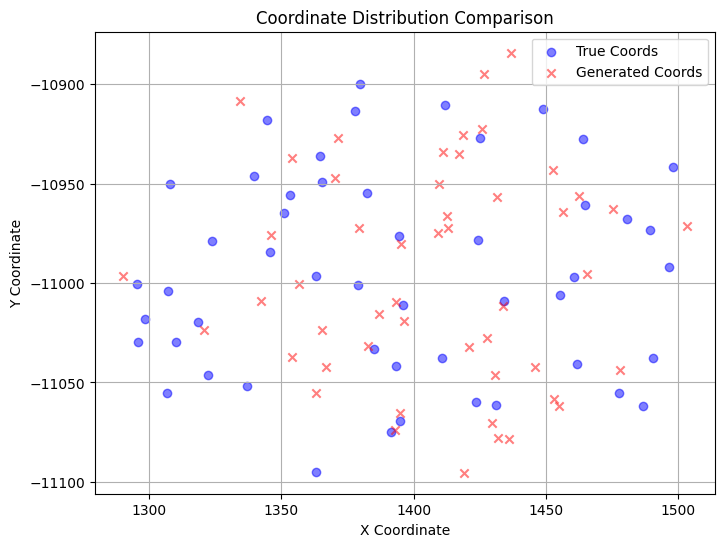

In [104]:
visualize_coords(true_coords, pred_coords)

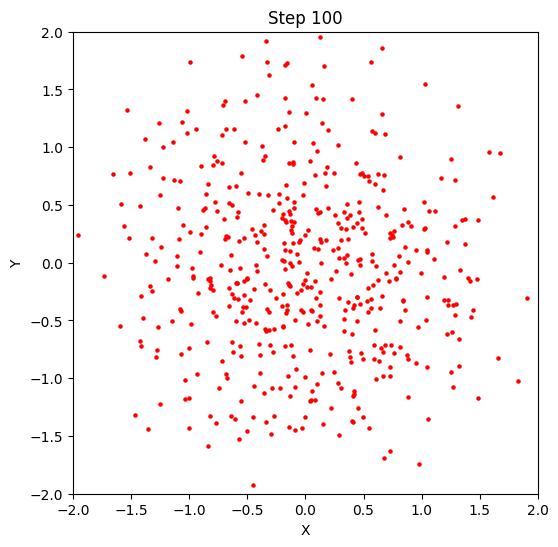

In [10]:
position = training_samples[1]['normalized_positions']
ani = visualize_noising_process_animation(model, position)
ani.save("./noising_process_animation_truncated.gif", writer='imagemagick', fps=10)